In [18]:
import pandas as pd
#DATAET
df = pd.read_csv('amazon.csv')

In [19]:
#REMOVE INNAPROPRIATED SYMBOLS IN THE COLUMNS TO CONVERT TO DECIMALS
df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
df['actual_price'] = df['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)

In [20]:
#CONVERTING RATINGS TO NUMBERS
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

In [21]:
#SPLITTING THE TEXT AT "|" TO TAKE THE FIRST PART
df['main_category'] = df['category'].str.split('|').str[0]

In [24]:
## GROUPING BY CATEGORY AND CALCULATING THE AVERAGE RATING
category_stats = df.groupby('main_category')['rating'].mean().sort_values(ascending=False)
print(category_stats)

main_category
OfficeProducts           4.309677
Toys&Games               4.300000
HomeImprovement          4.250000
Computers&Accessories    4.154967
Electronics              4.081749
Home&Kitchen             4.040716
Health&PersonalCare      4.000000
MusicalInstruments       3.900000
Car&Motorbike            3.800000
Name: rating, dtype: float64


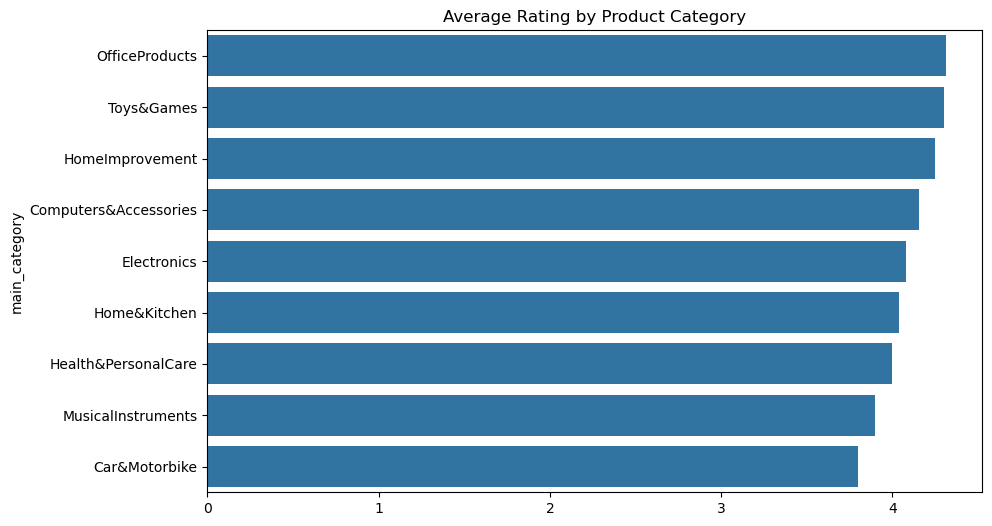

In [26]:
#VISUALIZING THE RESULTS WITH SEABORN AND MATPLOT

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=category_stats.values, y=category_stats.index)
plt.title('Average Rating by Product Category')
plt.savefig('my_analysis_plot.png')

Text(0.5, 1.0, 'Relationship Between Price and Rating')

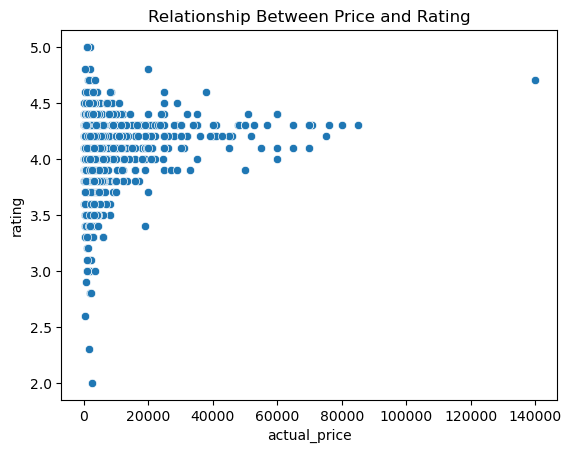

In [23]:
#CLEAN PRICE COLUMNS
sns.scatterplot(data=df, x='actual_price', y='rating')
plt.title('Relationship Between Price and Rating')

In [27]:
#REMOVING THE '%' SIGN AND CONVERTING TO DECIMAL NUMBER
df['discount_percentage'] = df['discount_percentage'].str.replace('%', '').astype(float)

# 2. Let's see the average discount across the whole dataset
avg_discount = df['discount_percentage'].mean()
print(f"The average discount offered is {avg_discount:.2f}%")

The average discount offered is 47.69%


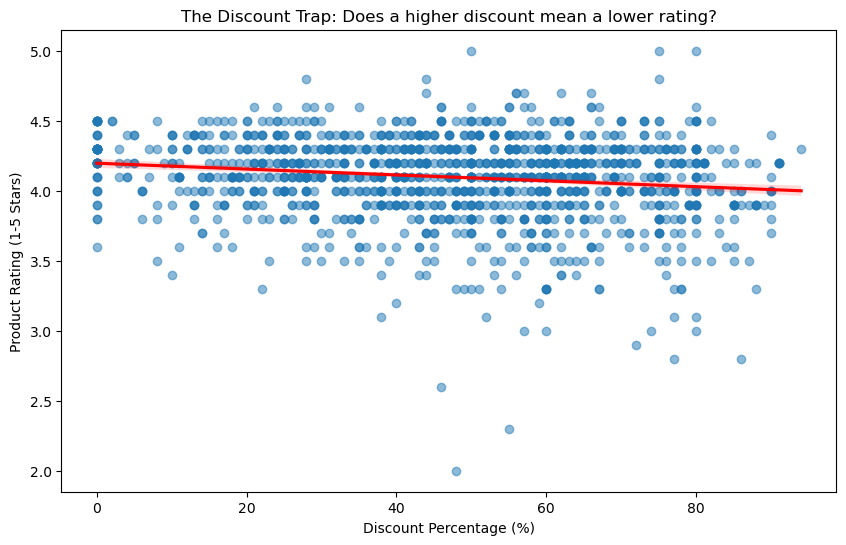

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create a scatter plot with a regression line
sns.regplot(data=df, x='discount_percentage', y='rating', 
            scatter_kws={'alpha':0.5},
            line_kws={'color':'red'})

plt.title('The Discount Trap: Does a higher discount mean a lower rating?')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Product Rating (1-5 Stars)')
plt.show()

In [31]:
#TO BE A HUNDRED PERCENT SURE ABOUT THE 
c = df['discount_percentage'].corr(df['rating'])
print(f"The correlation between discount and rating is: {c:.4f}")


The correlation between discount and rating is: -0.1554


In [35]:
#TRYING TO FIND THE TRAP BY CATEGORY, BECAUSE THE NUMBERS IS NEGATIVE, THERE IS A SLIGHT "DISCOUNT TRAP". AS THE DISCOUNT GOES UP, THE RATING TENDS TO GO DOWN.

# 1. Find categories that have at least 5 products
counts = df['main_category'].value_counts()
big_categories = counts[counts >= 5].index

# 2. Calculate correlation only for those big categories
# We add include_groups=False to stop the "FutureWarning"
category_correlations = df[df['main_category'].isin(big_categories)].groupby('main_category').apply(
    lambda x: x['discount_percentage'].corr(x['rating']),
    include_groups=False
).sort_values()

print("Meaningful Correlations (Lower = More of a Trap):")
print(category_correlations)

Meaningful Correlations (Lower = More of a Trap):
main_category
Home&Kitchen            -0.239087
Electronics             -0.178965
OfficeProducts          -0.135102
Computers&Accessories   -0.129261
dtype: float64


In [36]:
villain_category = 'Electronics' # <--- Change this based on your result!

# Find products in that category with high discounts but low ratings
offenders = df[
    (df['main_category'] == villain_category) & 
    (df['discount_percentage'] > 50) & 
    (df['rating'] < 3.8)
]

print(f"Top Offenders in {villain_category}:")
print(offenders[['product_name', 'discount_percentage', 'rating']].head())

Top Offenders in Electronics:
                                          product_name  discount_percentage  \
48   7SEVEN® Compatible for Samsung Smart 4K Ultra ...                 60.0   
55                           Tata Sky Universal Remote                 54.0   
60   Airtel DigitalTV DTH Television, Setup Box Rem...                 78.0   
82   SKYWALL 81.28 cm (32 inches) HD Ready Smart LE...                 62.0   
121  Remote Control Compatible for Amazon Fire Tv S...                 63.0   

     rating  
48      3.6  
55      3.7  
60      3.7  
82      3.4  
121     3.7  


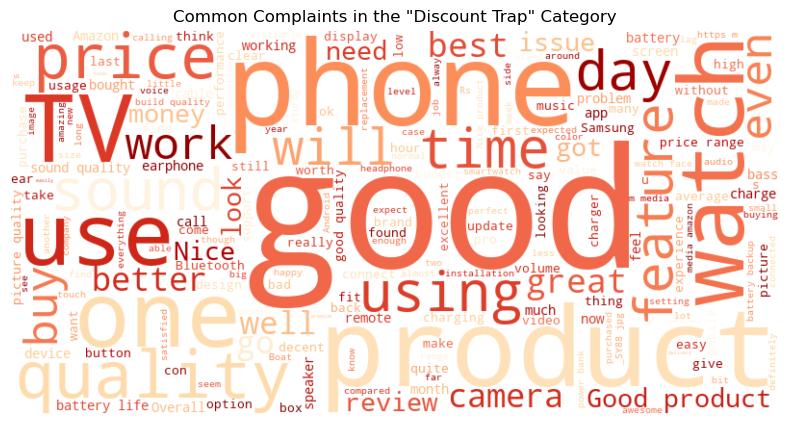

In [42]:
#THE HUMAN FACTOR

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Get all reviews from your "Villain" category
# (Assuming 'Electronics' was your result)
villain_reviews = " ".join(df[df['main_category'] == 'Electronics']['review_content'].astype(str))

# 2. Create the Word Cloud
# If you get a ModuleNotFoundError again, you need to run: !pip install wordcloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', 
                      colormap='OrRd').generate(villain_reviews)

# 3. Display it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Complaints in the "Discount Trap" Category')
plt.show()